# Progetto Corò Elia

In [1]:
# import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk

In [2]:
# Load the dataset
data = pd.read_csv('train.csv')
data

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955,ff8a2de4,Fall,13,0,Spring,60.0,Fall,16.362460,59.5,82.4,...,1.0,1.0,0.0,32.0,Winter,35.0,50.0,Fall,1.0,1.0
3956,ffa9794a,Winter,10,0,NaN,NaN,Spring,18.764678,53.5,76.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Winter,0.0,NaN
3957,ffcd4dbd,Fall,11,0,Spring,68.0,Winter,21.441500,60.0,109.8,...,1.0,0.0,1.0,31.0,Winter,56.0,77.0,Fall,0.0,1.0
3958,ffed1dd5,Spring,13,0,Spring,70.0,Winter,12.235895,70.7,87.0,...,1.0,1.0,1.0,19.0,Spring,33.0,47.0,Spring,1.0,0.0


## Data Initial Cleaning

In [3]:
import pandas as pd
from cleaning.remove_high_missing_fields import remove_high_missing_fields
from cleaning.remove_high_missing_columns import remove_high_missing_columns

# Reload dataset
data = pd.read_csv('train.csv')

# Removed columns which are not present in the test set
test_columns = list(pd.read_csv('test.csv').columns) + ['sii']
data = data[test_columns]

# Removed id column
data = data.drop(columns=['id'])

# Removed columns with more than 50% missing values
data, column = remove_high_missing_columns(data, threshold=0.50)
print("column removed " + str(len(column)))

# Removed rows where sii is invalid
data = data[data['sii'].notna()]

# Removed rows with more than 80% missing values
data, data_removed = remove_high_missing_fields(data, threshold=0.9)
print("row removed " + str(len(data_removed)))
print(len(data))

data
X = data.copy


column removed 13
row removed 0
2736


In [4]:
from cleaning.one_hot_encoder import OneHotEncoderFunction

data = OneHotEncoderFunction(data)
data


,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,...,BIA-Season_Winter,BIA-Season_nan,SDS-Season_Spring,SDS-Season_Summer,SDS-Season_Winter,SDS-Season_nan,PreInt_EduHx-Season_Spring,PreInt_EduHx-Season_Summer,PreInt_EduHx-Season_Winter,PreInt_EduHx-Season_nan
0,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.061430,9.21377,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.211720,3.97085,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.220330,18.82430,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5,2.0,4.33036,30.1865,1330.970,1996.45,30.21240,84.0285,16.6877,13.498800,67.97150,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3953,3.0,3.20303,17.1417,1035.270,1759.96,11.00630,52.5331,13.4004,3.741300,14.66690,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3954,1.0,2.36680,13.6457,966.287,1256.17,9.98802,45.1853,13.2315,0.414263,1.41470,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3955,3.0,4.52277,16.3642,1206.880,2051.70,19.46110,70.8117,14.0629,2.301380,11.58830,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3957,2.0,4.41305,21.4438,1253.740,2005.99,20.48250,75.8033,14.8043,6.639520,33.99670,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [5]:
from sklearn.experimental import enable_iterative_imputer
from cleaning.fill_missing_values import fill_missing_values

data = fill_missing_values(data)

data

,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,...,BIA-Season_Winter,BIA-Season_nan,SDS-Season_Spring,SDS-Season_Summer,SDS-Season_Winter,SDS-Season_nan,PreInt_EduHx-Season_Spring,PreInt_EduHx-Season_Summer,PreInt_EduHx-Season_Winter,PreInt_EduHx-Season_nan
0,2.00,2.668550,16.879200,932.4980,1492.0000,8.25598,41.58620,13.817700,3.061430,9.21377,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2.00,2.579490,14.037100,936.6560,1498.6500,6.01993,42.02910,12.825400,1.211720,3.97085,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2.76,4.277348,16.650193,1237.2228,2061.7279,20.86041,74.05611,14.068083,2.959732,13.62392,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,3.00,3.841910,18.294300,1131.4300,1923.4400,15.59250,62.77570,14.074000,4.220330,18.82430,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5,2.00,4.330360,30.186500,1330.9700,1996.4500,30.21240,84.02850,16.687700,13.498800,67.97150,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3953,3.00,3.203030,17.141700,1035.2700,1759.9600,11.00630,52.53310,13.400400,3.741300,14.66690,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3954,1.00,2.366800,13.645700,966.2870,1256.1700,9.98802,45.18530,13.231500,0.414263,1.41470,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3955,3.00,4.522770,16.364200,1206.8800,2051.7000,19.46110,70.81170,14.062900,2.301380,11.58830,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3957,2.00,4.413050,21.443800,1253.7400,2005.9900,20.48250,75.80330,14.804300,6.639520,33.99670,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


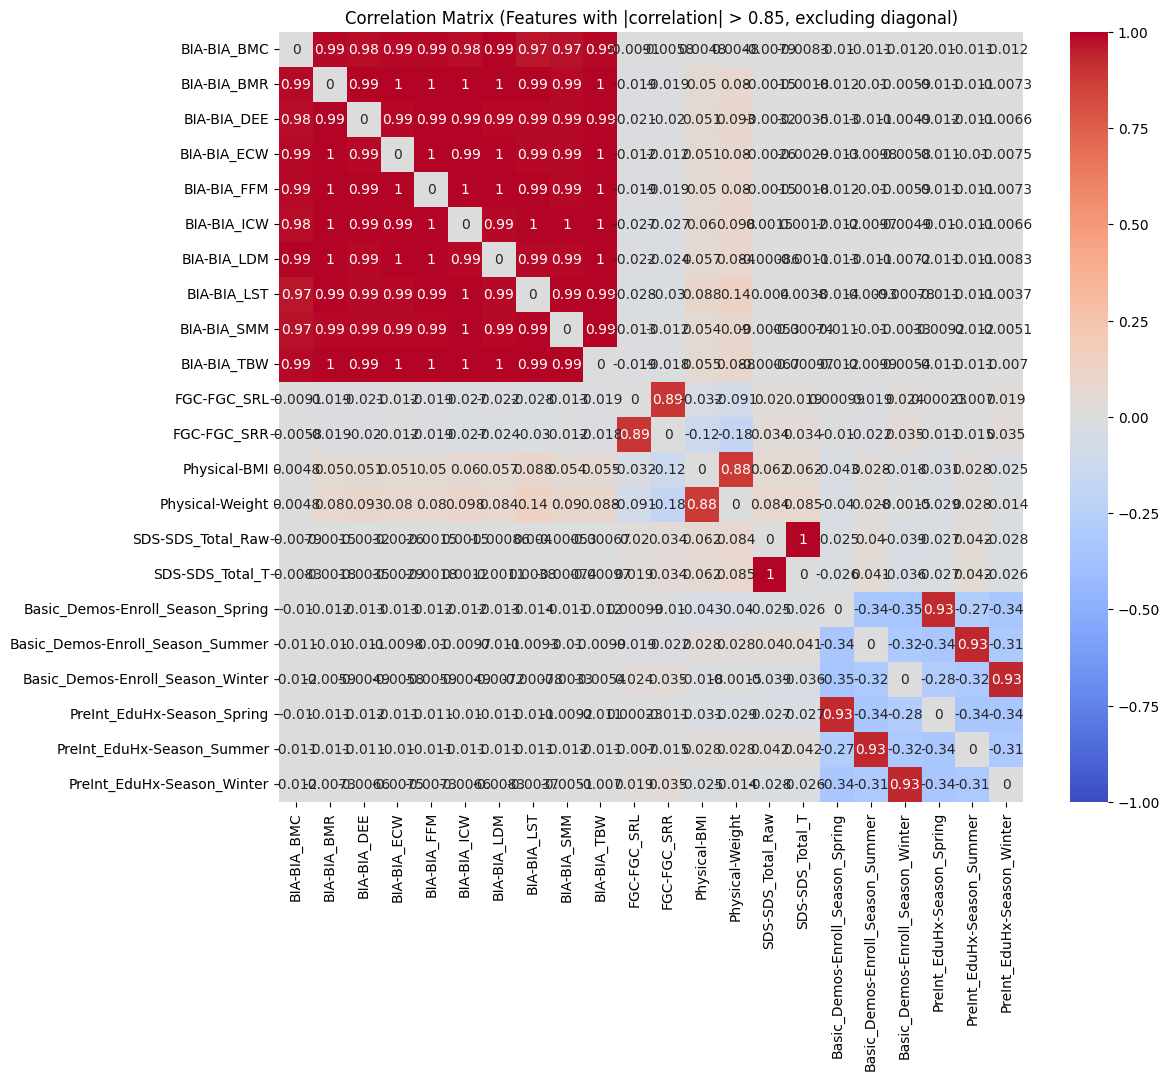

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = data.corr()

threshold = 0.85

# Rimuovi la diagonale settando i valori a 0
np.fill_diagonal(corr_matrix.values, 0)

# Trova le colonne che hanno almeno una correlazione superiore alla soglia (escludendo la diagonale)
high_corr_vars = corr_matrix.columns[(corr_matrix > threshold).any()]

# Filtra la matrice di correlazione per mantenere solo le variabili altamente correlate
filtered_corr_matrix = corr_matrix.loc[high_corr_vars, high_corr_vars]

# Visualizza la matrice di correlazione filtrata
plt.figure(figsize=(12, 10))
sns.heatmap(filtered_corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title(f"Correlation Matrix (Features with |correlation| > {threshold}, excluding diagonal)")
plt.show()



Bia + Physical BMI provarle tutte e vedere la migliore
FGC-FGC_SRL, FGC-FGC_SRR prendere la media
togliere FGC-FGC_SRL_Zone
prendere SDS-SDS_Total_T ed escludere SDS-SDS_Total_Raw
Tutte le colonne PreInt_EduHx-Season le togliamo, sono colonne che indicano quando sono stati raccolti dati di interesse, ma di per sè sapere quando questi vengono raccolti non ce ne ciava un cazzo :)



In [7]:
# take all BMI columns
bmi_columns = [col for col in data.columns if 'BIA' in col and col != 'BIA-BIA_BMI' ]
data['FGC-FGC_SRM'] = (data['FGC-FGC_SRL'] + data['FGC-FGC_SRR']) / 2
data = data.drop(columns=['FGC-FGC_SRL_Zone', 'SDS-SDS_Total_Raw'])
if 'SDS-SDS_Total_Raw' in data.columns:
    data = data.drop('SDS-SDS_Total_Raw')
preint_season_column = [col for col in data.columns if 'PreInt_EduHx-Season' in col]
data = data.drop(columns=preint_season_column)

In [10]:
import pandas as pd

import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np


def calculate_vif(X):
    # Crea un DataFrame per conservare i risultati del VIF
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns

    # Calcola il VIF per ciascuna variabile
    vif_data["VIF"] = [
        1 / (1 - LinearRegression().fit(X.drop(columns=[col]), X[col]).score(X.drop(columns=[col]), X[col]))
        for col in X.columns
    ]

    return vif_data


# Esempio di utilizzo
# vif_data = calculate_vif(data)
#print(vif_data)


## Data preparation

In [ ]:
from cleaning.rfecv_selection import rfecv_selection

column_number = rfecv_selection(data)
column_number

In [ ]:
from cleaning.rfe_selection import rfe_selection

y = data['sii']
X = data.drop(columns=['sii'])

column = rfe_selection(X, y, column_number)

data = pd.concat([X[column], y], axis=1)
column

In [ ]:
from cleaning.gred_search_rf import grid_search_rf

y = data['sii']
X = data.drop(columns=['sii'])

parameters = grid_search_rf(X, y)

data = pd.concat([X, y], axis=1)

parameters


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

model = RandomForestClassifier(**parameters)

model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

n_estimators_range = range(1, 150, 10)
train_accuracies = []
test_accuracies = []

for n in n_estimators_range:
    model = RandomForestClassifier(
        max_depth=parameters['max_depth'],
        min_samples_leaf=parameters['min_samples_leaf'],
        min_samples_split=parameters['min_samples_split'],
        n_estimators=n
    )
    model.fit(X_train, y_train)
    train_accuracies.append(accuracy_score(y_train, model.predict(X_train)))
    test_accuracies.append(accuracy_score(y_test, model.predict(X_test)))

# Grafico delle accuratezze per il numero di alberi
plt.figure(figsize=(12, 6))
plt.plot(n_estimators_range, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(n_estimators_range, test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Accuracy")
plt.title("Learning Curve: Train vs Test Accuracy")
plt.legend()
plt.grid()
plt.show()


In [ ]:
import pandas as pd

import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np


def calculate_vif(X):
    # Crea un DataFrame per conservare i risultati del VIF
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns

    # Calcola il VIF per ciascuna variabile
    vif_data["VIF"] = [
        1 / (1 - LinearRegression().fit(X.drop(columns=[col]), X[col]).score(X.drop(columns=[col]), X[col]))
        for col in X.columns
    ]

    return vif_data


# Esempio di utilizzo
vif_data = calculate_vif(X)
print(vif_data)
